# 1. Import Dependencies and Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds # Bringing Tensorflow datasets for fashion mnist
from matplotlib import pyplot as plt
import numpy as np # For data Transformation.

# 2. Build Data and Viz Data

In [2]:
# loading 'fashion mnist' data-set from Tensorflow(loading only training-data)
ds = tfds.load('fashion_mnist', split='train')

In [5]:
itr = ds.as_numpy_iterator()

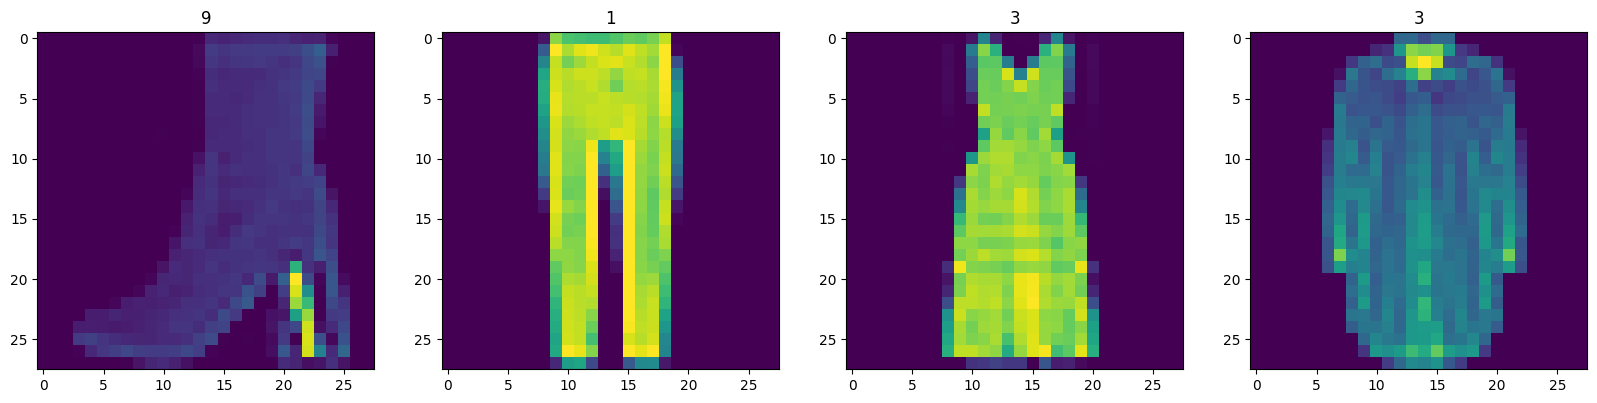

In [19]:
# Viz Training Data-set(loading from Tensorflow)
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for indx in range(4):
    sample = itr.next()
    ax[indx].imshow(np.squeeze(sample['image'])) # np.squeeze() - Removes dimentions of size 1(simplifies data shape and makes simpler to work with) eg: (28, 28, 1) ---> (28, 28)
    ax[indx].title.set_text(sample['label'])

In [20]:
# Scale data(between 0 to 1), and returns Image only(because we don't need lables)
def normalize(sample):
    img = sample['image'] # Extract Image only.
    return img / 255 

In [21]:
# Data Pre-Processing
# Normalize-data
ds = ds.map(normalize) # map() is used to apply a function to each element in a dataset
# Chache dataset(for fast access to data-set after first-access)
ds = ds.cache()
# Shuffle data-set(shuffle order of dataset, makes sure data fed to model in a random order)
ds = ds.shuffle(60000)
# Batch-data into 128 images
ds = ds.batch(128)
#Prefetch( allows the dataset to preload the next batch while the current one is being processed, improving the overall speed of your training.)
ds = ds.prefetch(64) # 64 batches will be preloaded

In [22]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

#### 3.1 Import Modelling Components

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, UpSampling2D, Dropout, LeakyReLU

#### 3.2 Build Generator

In [24]:
def generator():
    model = Sequential()

    #Input-layer(takes 128-random numbers(flatten)) and reshapes it to 7*7*128(not flatten(3D)) 
    model.add(Dense(7 * 7 * 128, input_dim=128)) # Preparing output for Convolutional-layer. 
    # 7*7*128 ---> No.of Neurans, This Dense layer takes an input vector of size 128 and outputs a vector of size 7×7×128=6272
    model.add(LeakyReLU(0.2))
    # Reshape will reshape output of dense-layer to (7, 7, 128) - (7*7 image with 128 layers).
    model.add(Reshape((7, 7, 128))) # takes input from dense-layer(7*7*128), and reshape it to a 3D(H*W*channels) tensor for use in the convolutional layers.
    # Note: 
    # input for Convolutional-layer should  be 3D tensor.(W*H*chanells) 
    # Thus, 128 channels represent 128 different feature maps, each of size 7×7, generated by the Convolutional-network to capture various aspects(features) of the image or data being processed.

    # WE NEED TO CONVERT/UPSAMPLE 7*7*128(RESHAPED) TO 28*28*1(FINAL-IMAGE).

    # WE ADD MULTIPLE CONVOLUTIONAL-LAYERS TO EXTRACT MORE AND MORE FEATURES FROM AN IMAGE.
    # CONVOLUTIONAL-LAYERS ARE USED IN GAN-GENERATOR TO CAPTURE SPATIAL RELATIONSHIPS, AND GENERATE DETAILED FEATURES.
    
    # 1st Upsampleing(increase(double) the size of image)
    model.add(UpSampling2D()) # This layer increases the spatial dimensions (height and width) ---> 14*14
    model.add(Conv2D(128,(5, 5), padding='same')) # To capture spatial relationships, and generate detailed features. Outputs 128 Feature-Maps, each of which captures different aspects of the input.
    model.add(LeakyReLU(0.2))

    # 2nd Upsampleing(increase(double) the size of image)
    model.add(UpSampling2D()) # ---> 28*28
    model.add(Conv2D(128,(5, 5), padding='same')) # To capture spatial relationships, and generate detailed features. Outputs 128 Feature-Maps.
    model.add(LeakyReLU(0.2))

    # COVOLUTION-LAYER(TO CAPTURE FEATURES FROM IT'S INPUTS)
    model.add(Conv2D(128, (4, 4), padding='same'))
    model.add(LeakyReLU(0.2))

    # COVOLUTION-LAYER(TO CAPTURE FEATURES FROM IT'S INPUTS)
    model.add(Conv2D(128, (4, 4), padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolution-layer to get one channel.
    model.add(Conv2D(1, (4, 4), padding='same', activation='sigmoid')) # To make image of same size as Images in data-set. 
    return model 

In [25]:
# Optional
generator = generator()
generator.summary()

C:\Users\Sohail Mohammed\OneDrive\Desktop\GANs\GFashion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


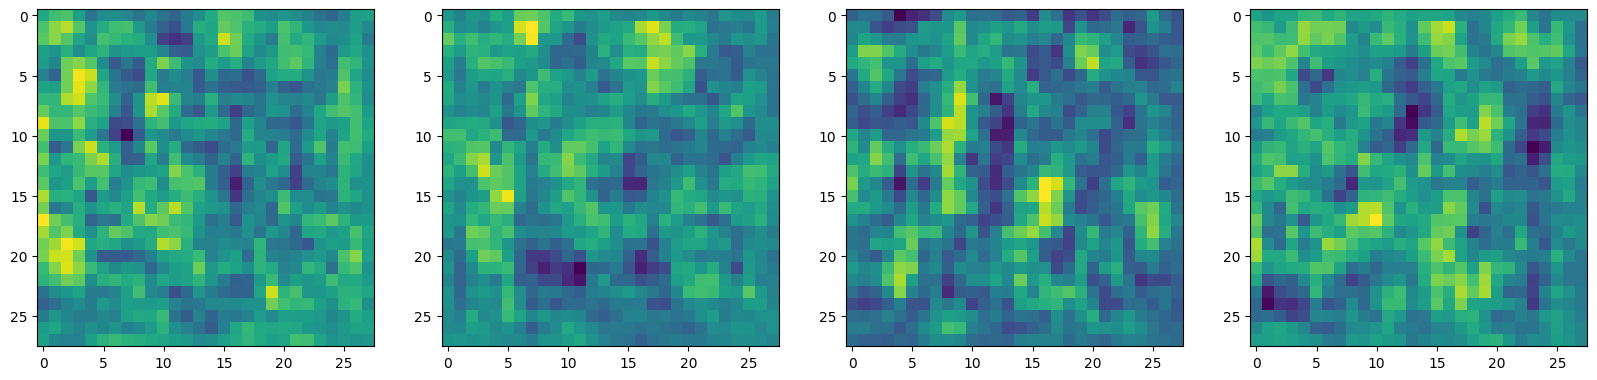

In [31]:
# Generate Image
img = generator.predict(np.random.randn(4, 128, 1)) # Generating 4 different random-Images
# Visualize Generated Image.
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for indx in range(4):
    ax[indx].imshow(np.squeeze(img[indx])) # np.squeeze() - Removes dimentions of size 1(simplifies data shape and makes simpler to work with) eg: (28, 28, 1) ---> (28, 28)

#### 3.3 Build Discriminator

In [32]:
# Discriminator == Image-classifier(identifying 'real' or 'fake').
def discriminator():
    model = Sequential()

    # 1st Convolutoinal-layer to read input(image)
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) # Regulation(to avoid over-fitting)

    # 2nd Convolutoinal-layer to read input(image)
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) 

    # 3nd Convolutoinal-layer to read input(image)
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) 

    # 4th Convolutoinal-layer to read input(image)
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) 

    # Flatten to a single-vector.
    model.add(Flatten())
    model.add(Dropout(0.4)) 

    # Dense-layer
    model.add(Dense(1, activation='sigmoid')) # For Binary-classification(0 or 1).
    return model

In [33]:
discriminator = discriminator()
discriminator.summary()

C:\Users\Sohail Mohammed\OneDrive\Desktop\GANs\GFashion\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Construct Training Loop

#### 4.1 Setup Losses and Optimizers

In [36]:
# Training-Loop: We need to train both Generator and Discriminator side-by-side(should balance training-phase of both --- difficult part), unlike using model.fit().
from tensorflow.keras.optimizers import Adam # Optimizer(updates/adjustes the weights based on loss-function during training) for both generator and dicriminator.
from tensorflow.keras.losses import BinaryCrossentropy # Loss-Function used for binary-classifiction. It measures the difference between predicted and actual outcomes.
# NOTE: 
# In GANs "BinaryCrossentropy" is used for Generator and Discriminator.
# Binary Crossentropy helps the generator learn to fool the discriminator by minimizing the difference between fake and real image classifications.
#In the context of GANs, these tools are critical for balancing the adversarial training between the generator (which creates fake data) 
# and the discriminator (which tries to identify real vs. fake data).

In [37]:
# Create Instances
opt_g = Adam(learning_rate = 0.0001) # Optimizer for Generator.
opt_d = Adam(learning_rate = 0.00001) # Optimizer for Discriminator.

loss = BinaryCrossentropy() # Loss for both

 #### 4.2 Build Subclasses Model

#### 4.3 Build Callback

#### 4.4 Train

#### 4.5 Review Performance